In [2]:
# data preparation + loading
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# general processingy
from skimage import io
import matplotlib.pyplot as plt
import PIL.Image as Image

# useful tools
import pandas as pd
import numpy as np
import os

In [3]:
## confirm that current device is cuda compatible ##
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0) + " is ready and CUDA compatible")
else:
    print("Not CUDA compatible device")

NVIDIA GeForce RTX 3060 Ti is ready and CUDA compatible


In [4]:
### --- Create New annotated_truth label file --- ###
def create_annotated_truth():
    df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
    df.to_csv('annotated_truth.csv')
    df['Category'] = 0
    df['image'] = df['image'] + '.jpg'
    for i in range(0, df.shape[0]):
        for j in range(1, 9):
            if df.iloc[i, j] == 1.0:
                df.iloc[i, 10] = j
    df.to_csv('annotated_truth.csv')
# create_annotated_truth()

In [5]:
### --- MelanomaDataset Class --- ###
class MelanomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])  #think this works
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 11]))
        if self.transform:
            image = self.transform(image) 
        return image, y_label

In [6]:
### --- Print first file not downloaded --- ###
def remove_missing():
    df = pd.read_csv('annotated_truth.csv')
    for i in range(len(df['image'])):
        if not os.path.exists('./data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + df['image'][i]):
            print(df['image'][i])
            break
    print('All images are present!')       
remove_missing()

All images are present!


In [7]:
### --- Create data transforms --- ###
data_transforms = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ## TODO - normalize to mean and std
])

In [8]:
### --- Create dataset --- ###
dataset = MelanomaDataset(csv_file='annotated_truth.csv',
                          root_dir='data/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                          transform=data_transforms)

In [9]:
### --- Print number of image labels we have --- ###
df = pd.read_csv('annotated_truth.csv')
print(len(df['image']))

25331


In [10]:
### --- Create train, test split; Create Dataloaders --- ###
train_set, test_set = torch.utils.data.random_split(dataset, [20265, 5066])
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

ak ak nv mel mel nv bcc nv nv nv scc nv nv nv mel nv nv bkl bcc bcc bkl mel bkl mel nv bkl nv nv nv nv bcc bcc 

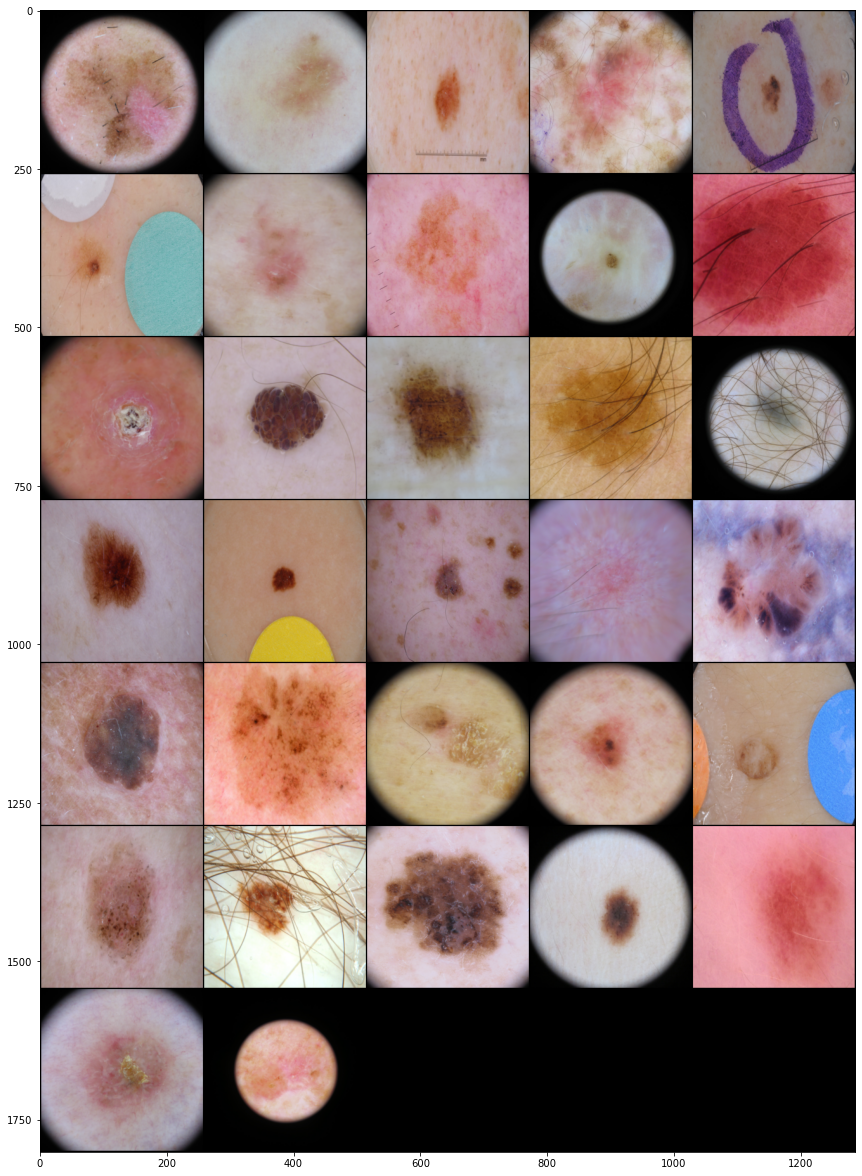

In [11]:
### --- Display labelled images in dataset --- ###

# define categories
categories = ['null', 'mel', 'nv', 'bcc', 'ak', 'bkl', 'df', 'vasc', 'scc', 'unk']

# get some random training images
dataiter = next(iter(train_loader))
images, labels = dataiter

# show images
grid = make_grid(images, nrow=5)
plt.figure(figsize=(21, 21))
plt.imshow(np.transpose(grid, (1,2,0)))
for label in labels:
    print(categories[label], end=" ")